# Pre-Class 4.1

## General Implementation Notes

* I implemented the model using mostly numpy operations alone. I allowed for loops for simplicity only if they would run at O(1) or O(n_lanes) at the Rickert models (n_lanes is very small) since these would improve readability, be more simple, and not cost too much computation and maintain the high efficiency of the code.

In [1]:
import matplotlib
import pylab
import random
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
plt.style.use('ggplot')

In [125]:
### Attempt to implement with numpy arrays ###

class TrafficSimulator(object):
    
    def __init__(self, length=50, density=0.2, vMax=5, slowProb=0.5):
        '''
        Initialize new TrafficSimulator objects with the default parameter
        settings. 

        Inputs:

         * length (int): The number of cells in the cellular automaton.
           Default: 50.

         * density (float): The proportion of cells that will be active (contain
           a car) when the cellular automaton is initialized. The active cells
           will be at random locations along the length of the CA. Default: 0.2.
           
        * vMax (int): The maximum velocity of the cars. Default: 5.
        
        * slowProb (float): The probability of a car to randomly slow down. 
          Default: 0.5.
        

        '''
        self.length = length
        self.density = density
        self.vMax = vMax
        self.slowProb = slowProb
        self.flowPerStep = []

        # Arrays for storing the current state and the next state (when we are
        # busy doing a state update).
        self.current_state = np.ones(self.length) * -1
        self.next_state = np.ones(self.length) * -1

    def initialize(self, initSpeed_zero=True):
        '''
        Initialize the state - set up cars in place and give an initial speed. 
        
        * initSpeed_zero (bolean): if True, set all initial velocities to zero. 
          If False, set the veloities to the maximum possible.
        
        '''
        # Set up a random initial state where the fraction of 0s in the array
        # equals the density parameter.
        random_indices = np.random.choice(
            range(self.length),
            size=int(round(self.density * self.length)),
            replace=False)
        self.current_state.fill(-1)
        self.current_state[random_indices] = 0
        
        if not initSpeed_zero:
            # Set the velocities to the max possible (i.e, distant - 1 or max velocity)
            for i in range(self.length):
                if self.current_state[i] != -1:
                    for j in range(1, self.vMax+1):
                        if self.current_state[(i+j)%self.length] != -1:
                            dist = j
                            break
                        dist = self.vMax+1
                    self.current_state[i] = dist-1

        self.time = 0
        
    def draw(self):
        '''
        Draw the current state of the cellular automaton.
        '''
        print(''.join('.' if x == -1 else str(int(x)) for x in self.current_state))

    def update_velocities_noOpt(self):
        '''
        Update all velocities according to rules 1-3.
        This method uses for loops in its implementation.
        '''
        for i in range(self.length):
            if self.current_state[i] != -1:
                # Calculate the distance to next car (if distance is long, set as vMax+1)
                for j in range(1, self.vMax+1):
                    if self.current_state[(i+j)%self.length] != -1:
                        dist = j
                        break
                    dist = self.vMax+1
                # Rule 1: acceleration
                if (self.current_state[i] < self.vMax) and (dist > self.current_state[i]+1):
                    self.current_state[i] += 1
                # Rule 2: slowing down
                if self.current_state[i] >= dist:
                    self.current_state[i] = dist-1
                # Rule 3: randomization
                if self.current_state[i] != 0:
                    if random.random() < self.slowProb:
                        self.current_state[i] -= 1
        
    def update_velocities(self):
        '''
        Update all velocities according to rules 1-3.
        This method uses numpy arrays in its implementation.
        '''
        # Rule 1: acceleration
        self.current_state[np.where((self.current_state < 5) & (self.current_state >= 0))] += 1
        
        # Rule 2: slowing down
        ## Get the indices of all cars
        cars_index = np.where(self.current_state > -1)[0]
        
        ## Find the distance between cars
        extended_current_state = np.append(self.current_state, self.current_state[:cars_index[0]+1])
        dist_between_cars = np.ediff1d(np.where(extended_current_state > -1)) - 1
        dist = np.ones(self.length) * -1
        dist[cars_index] = dist_between_cars
        
        ## Take the minimum between the current velocity and the distance to the next car (- 1)
        self.current_state = np.minimum(self.current_state, dist)
        
        # Rule 3: randomization
        randomized_cars = np.random.random(self.length) < self.slowProb
        self.current_state[np.where(randomized_cars & (self.current_state > 0))] -= 1
        

    def step_noOpt(self):
        '''
        Update the positions based on updated velocities according to rule 4.
        This method uses for loops in its implementation.
        '''
        # Update the new positions (rule 4)
        current_flow = 0
        self.next_state = np.ones(self.length) * -1
        for i in range(self.length):
            if self.current_state[i] != -1:
                self.next_state[int((i + self.current_state[i])%self.length)] = self.current_state[i]
                if i + self.current_state[i] >= self.length:
                    current_flow += 1
        
        # Swap next state and current state
        self.current_state, self.next_state = self.next_state, self.current_state
        self.time += 1
        self.flowPerStep.append(current_flow)
        
        
    def step(self):
        '''
        Update the positions based on updated velocities according to rule 4.
        This method uses numpy arrays in its implementation.
        '''
        # Update the new positions (rule 4)
        self.next_state = np.ones(self.length) * -1
        cars_index = np.where(self.current_state > -1)[0]
        cars_index_updated = cars_index + self.current_state[cars_index].astype(int)
        self.next_state[cars_index_updated%self.length] = self.current_state[cars_index]
        
        # Get the flow of the step (it's a for-loop, I know, but O(1) so we're good)
        current_flow = 0
        for i in range(self.length-self.vMax, self.length):
            if i + self.current_state[i] >= self.length:
                current_flow += 1

        # Swap next state and current state
        self.current_state, self.next_state = self.next_state, self.current_state
        self.time += 1
        self.flowPerStep.append(current_flow)


In [120]:
sim = TrafficSimulator(length=15, density=0.2, vMax=5, slowProb=0.5)
sim.initialize(initSpeed_zero=False)
a = sim.current_state.copy()
print(a)



[-1. -1.  5. -1. -1. -1. -1. -1. -1. -1. -1.  0.  4. -1. -1.]


## Nagel & Schreckenberg - figure 1

In [126]:
sim = TrafficSimulator(length=100, density=0.03, vMax=5, slowProb=0.5)
sim.initialize()
sim.current_state
# sim.draw()
for i in range(20):
    sim.update_velocities()
    sim.draw()
    sim.step()

0..................1................................1...............................................
0...................2................................1..............................................
0.....................3...............................1.............................................
1........................3.............................1............................................
.1..........................3...........................1...........................................
..2............................4.........................1..........................................
....3..............................4......................2.........................................
.......4...............................4....................3.......................................
...........4...............................4...................4....................................
...............5...............................5...................4.......................

In [127]:
print(sim.flowPerStep)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


## Nagel & Schreckenberg - figure 2

In [142]:
sim = TrafficSimulator(length=100, density=0.1, vMax=5, slowProb=0.5)
sim.initialize()
sim.current_state
# sim.draw()
for i in range(30):
    sim.update_velocities()
    sim.draw()
    sim.step()

.1...0.......1......1...........................1..................0...0.1.............1...........1
0.1..0........2......2...........................1.................0...1..1.............2...........
0..0.1..........3......2..........................2................1....2..1..............3.........
1..0..1............4.....2..........................3...............2.....1.2................3......
.0.1...2...............2...3...........................3..............2....2..3.................4...
01..1....3...............2....4...........................3.............2....3...3..................
0.2..1......3..............3......5..........................3............3.....2...3...............
1...1.2........4..............3........5........................4............3....3....4............
.2...2..3..........4.............4..........5.......................5...........3....4.....5........
...3...2...3...........4.............4...........5.......................4.........4.....4.

In [129]:
print(sim.flowPerStep)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0]


In [455]:
%%time
sim = TrafficSimulator(length=10**6, density=0.03, vMax=5, slowProb=0.5)
sim.initialize()
sim.current_state
# sim.draw()
for i in range(1000):
    sim.update_velocities()
#     sim.draw()
    sim.step()

CPU times: user 19.6 s, sys: 2.05 s, total: 21.6 s
Wall time: 21.8 s


In [456]:
%%time
sim = TrafficSimulator(length=10**6, density=0.03, vMax=5, slowProb=0.5)
sim.initialize()
sim.current_state
# sim.draw()
for i in range(1000):
    sim.update_velocities_noOpt()
#     sim.draw()
    sim.step_noOpt()

CPU times: user 11min 11s, sys: 2.29 s, total: 11min 13s
Wall time: 11min 16s


## Nagel & Schreckenberg - figure 4

In [480]:
%%time
initial_density = np.arange(0.02, 0.8, 0.02)
flows = []
flow_CI = []
run_time = 400
Ntrials = 100

for dens in initial_density:
    flowsTemp = []
    for i in range(Ntrials):
        sim = TrafficSimulator(length=1000, density=dens, vMax=5, slowProb=0.5)
        sim.initialize()
        for i in range(run_time):
            sim.update_velocities()
            sim.step()
        flowsTemp.append(np.mean(sim.flowPerStep[run_time//2:]))
    flows.append(np.mean(flowsTemp))
    flow_CI.append((np.percentile(flowsTemp, 2.5), np.percentile(flowsTemp, 97.5)))
    print("Density: {d}; Flow: {f}; 95% CI: {C}".format(d=round(dens, 2), f=round(flows[-1], 2), C=flow_CI[-1]))


Density: 0.02; Flow: 0.09; 95% CI: (0.072375, 0.1)
Density: 0.04; Flow: 0.18; 95% CI: (0.16, 0.195)
Density: 0.06; Flow: 0.27; 95% CI: (0.25, 0.29)
Density: 0.08; Flow: 0.33; 95% CI: (0.285, 0.365)
Density: 0.1; Flow: 0.32; 95% CI: (0.28, 0.375)
Density: 0.12; Flow: 0.32; 95% CI: (0.27, 0.372625)
Density: 0.14; Flow: 0.31; 95% CI: (0.265, 0.367625)
Density: 0.16; Flow: 0.31; 95% CI: (0.257375, 0.355)
Density: 0.18; Flow: 0.3; 95% CI: (0.245, 0.35262499999999997)
Density: 0.2; Flow: 0.29; 95% CI: (0.237125, 0.33762499999999995)
Density: 0.22; Flow: 0.29; 95% CI: (0.227375, 0.34262499999999996)
Density: 0.24; Flow: 0.28; 95% CI: (0.235, 0.335)
Density: 0.26; Flow: 0.28; 95% CI: (0.21737499999999998, 0.3328749999999999)
Density: 0.28; Flow: 0.27; 95% CI: (0.22, 0.325)
Density: 0.3; Flow: 0.26; 95% CI: (0.21, 0.31262499999999993)
Density: 0.32; Flow: 0.26; 95% CI: (0.215, 0.31787499999999985)
Density: 0.34; Flow: 0.26; 95% CI: (0.21, 0.315)
Density: 0.36; Flow: 0.25; 95% CI: (0.205, 0.2876

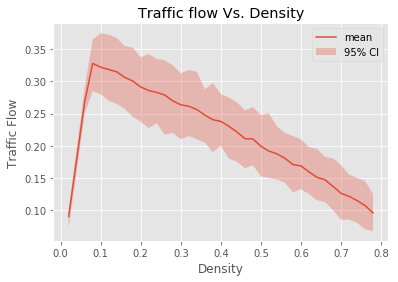

In [481]:
plt.plot(initial_density, flows, label="mean")
plt.fill_between(initial_density, [i[0] for i in flow_CI], [i[1] for i in flow_CI], alpha = 0.3, label = '95% CI')
plt.title("Traffic flow Vs. Density")
plt.xlabel("Density")
plt.ylabel("Traffic Flow")
plt.legend()
plt.show()

## Rickert et al. Implementation

In [2]:
class TrafficSimulator_Two_Lanes(object):
    
    def __init__(self, length=50, n_lanes=2, density=0.2, vMax=5, slowProb=0.5, switchLaneProb=1, look_back_other_lane=5):
        '''
        Initialize new TrafficSimulator objects with the default parameter
        settings. 

        Inputs:

         * length (int): The number of cells in the cellular automaton.
           Default: 50.

         * density (float): The proportion of cells that will be active (contain
           a car) when the cellular automaton is initialized. The active cells
           will be at random locations along the length of the CA. Default: 0.2.
           
        * vMax (int): The maximum velocity of the cars. Default: 5.
        
        * slowProb (float): The probability of a car to randomly slow down. 
          Default: 0.5.
        

        '''
        self.length = length
        self.density = density
        self.vMax = vMax
        self.slowProb = slowProb
        self.flowPerStep = []
        self.n_lanes = n_lanes
        self.look_back_other_lane = look_back_other_lane
        self.switchLaneProb = switchLaneProb
                 

        # Arrays for storing the current state and the next state (when we are
        # busy doing a state update).
        self.current_state = np.ones((self.n_lanes, self.length)) * -1
        self.next_state = np.ones((self.n_lanes, self.length)) * -1

    def initialize(self, initSpeed_zero=True):
        '''
        Initialize the state - set up cars in place and give an initial speed. 
        
        * initSpeed_zero (bolean): if True, set all initial velocities to zero. 
          If False, set the veloities to the maximum possible.
        
        '''        
        # Set up a random initial state where the fraction of 0s in the array
        # equals the density parameter.
        for i in range(self.n_lanes):
            random_indices = np.random.choice(
                range(self.length),
                size=int(round(self.density * self.length)),
                replace=False)
            self.current_state[i,].fill(-1)
            self.current_state[i, random_indices] = 0

        self.time = 0
        
    def draw(self, which_lane=0):
        '''
        Draw the current state of the cellular automaton - only one lane (which_lane).
        '''
        print(''.join('.' if x == -1 else str(int(x)) for x in self.current_state[which_lane,]))
        
    def draw_all_lanes(self):
        '''
        Draw the current state of the cellular automaton - all lanes.
        '''
        for lane in range(self.n_lanes):
            print(''.join('.' if x == -1 else str(int(x)) for x in self.current_state[lane,]))
        print("-"*self.length)
        
        
    def update_velocities(self):
        '''
        Update all velocities according to rules 1-3.
        This method uses numpy arrays in its implementation.
        '''
        
        for lane in range(self.n_lanes):  # no need to worry - O(n_lanes) operation and n_lanes is small
            # Rule 1: acceleration
            self.current_state[lane, np.where((self.current_state[lane, ] < 5) & (self.current_state[lane, ] >= 0))] += 1

            # Rule 2: slowing down
            ## Get the indices of all cars
            cars_index = np.where(self.current_state[lane, ] > -1)[0]

            ## Find the distance between cars
            extended_current_state = np.append(self.current_state[lane, ], self.current_state[lane, :cars_index[0]+1])
            dist_between_cars = np.ediff1d(np.where(extended_current_state > -1)) - 1
            dist = np.ones(self.length) * -1
            dist[cars_index] = dist_between_cars

            ## Take the minimum between the current velocity and the distance to the next car (- 1)
            self.current_state[lane, ] = np.minimum(self.current_state[lane, ], dist)

            # Rule 3: randomization
            randomized_cars = np.random.random(self.length) < self.slowProb
            self.current_state[lane, np.where(randomized_cars & (self.current_state[lane,] > 0))] -= 1
        
        
    def step(self):
        '''
        Update the positions based on updated velocities according to rule 4.
        This method uses numpy arrays in its implementation.
        '''
        self.next_state = np.ones((self.n_lanes, self.length)) * -1
        current_flow = 0
        for lane in range(self.n_lanes):  # no need to worry - O(n_lanes) operation and n_lanes is small
            # Update the new positions (rule 4)
            cars_index = np.where(self.current_state[lane, ] > -1)[0]
            cars_index_updated = cars_index + self.current_state[lane, cars_index].astype(int)
            self.next_state[lane, cars_index_updated%self.length] = self.current_state[lane, cars_index]

            # Get the flow of the step (it's a for-loop, I know, but O(1) so we're good)
            for i in range(self.length-self.vMax, self.length):
                if i + self.current_state[lane, i] >= self.length:
                    current_flow += 1

        # Swap next state and current state
        self.current_state, self.next_state = self.next_state, self.current_state
        self.time += 1
        self.flowPerStep.append(current_flow)
        
    
                
    def update_lanes(self):
        '''
        Update the lanes based on the rules from Rickert et al.
        '''
        ## Get the indices of all cars
        
        cars_index_all_lanes = []
        cars_bool_all_lanes = []
        for lane in range(sim.n_lanes):  # no need to worry - O(n_lanes) operation and n_lanes is small
            cars_index_all_lanes.append(np.where(sim.current_state[lane, ] > -1)[0])
            cars_bool_all_lanes.append(sim.current_state[lane, ] > -1)
            
        switch_lane = []
        for lane in range(self.n_lanes):
            # Rule 1: check gap ahead in your lane
            ## Find the distance between cars
            extended_current_state = np.append(self.current_state[lane, ], self.current_state[lane, :cars_index_all_lanes[lane][0]+1])
            dist_between_cars = np.ediff1d(np.where(extended_current_state > -1)) - 1
            dist = np.ones(self.length) * -1
            dist[cars_index_all_lanes[lane]] = dist_between_cars
            ## Compare the distance to the velocity (cars_ahead_my_lane is True if speed is greater than distance)
            cars_ahead_my_lane = dist < self.current_state[lane, ]
#             print(self.current_state[lane, ])
#             print(dist)
#             print(cars_ahead_my_lane)

            # Rule 2: check gap ahead in the lanes to your right and left
            # Rule 3: check gap backwards in other lanes
            no_cars_ahead_other_lane = []
            no_cars_back_other_lane = []
            for other_lane in [(lane+1)%self.n_lanes, (lane-1)%self.n_lanes]:
                ## Find the distance between cars in the current lane and the ones in the other lanes
                ### Roll the other lane vMax+1 times ahead, and catch the closest distances
                dist_ahead_other_lane = np.ones(self.length) * (self.vMax + 1)
                for i in range(-(self.vMax+1), 1):
                    dist_ahead_other_lane[cars_bool_all_lanes[lane] & np.roll(cars_bool_all_lanes[other_lane], i)] = -i -1
                no_cars_ahead_other_lane.append(dist_ahead_other_lane > self.current_state[lane, ])
                ### Roll the other lane l_o_back times backwards, and catch the closest distances
                look_back = np.full(self.length, True, dtype=bool)
                for i in range(1, self.look_back_other_lane+1):
                    look_back[cars_bool_all_lanes[lane] & np.roll(cars_bool_all_lanes[other_lane], i)] = False                
                no_cars_back_other_lane.append(look_back)
#             print(self.current_state[0, ])
#             print(self.current_state[1, ])
#             print((no_cars_back_other_lane & cars_bool_all_lanes[lane]))

            ### For now assuming only 2 lanes ###
            # Rule 4: randomization
            randomized_switch_lane = np.random.random(self.length) < self.switchLaneProb
            
            
            switch_lane.append(cars_ahead_my_lane & no_cars_ahead_other_lane[0] & \
                          no_cars_back_other_lane[0] & randomized_switch_lane)
        
        ### For now assuming only 2 lanes ###
        # Move the cars between lanes - take a car from its lane to another one, set the original space as -1
        for lane in range(self.n_lanes):
            self.current_state[(lane+1)%self.n_lanes, switch_lane[lane]] = self.current_state[lane, switch_lane[lane]]
            self.current_state[lane, switch_lane[lane]] = -1
        

## Play with visualizations

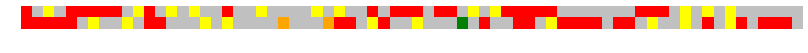

In [3]:
# A simple imshow visualization

sim = TrafficSimulator_Two_Lanes(length=100, density=0.5, vMax=5, slowProb=0.5)
sim.initialize()
sim.update_velocities()
sim.step()
states = []
for _ in range(100):
#     sim.draw_all_lanes()
    sim.update_lanes()
    sim.update_velocities()
#     sim.draw_all_lanes()
    sim.step()
    states.append(sim.current_state[:, :70])
    

# make a color map of fixed colors
cmap = colors.ListedColormap(['#C0C0C0', 'red', 'yellow', 'green', 'orange', 'pink', 'blue'])
bounds=[-1, 0, 1, 2, 3, 4, 5, 10]
norm = colors.BoundaryNorm(bounds, cmap.N)
    
fig, ax = plt.subplots(figsize=(14, 5))
# sim.draw_all_lanes()
fig = plt.imshow(sim.current_state[:, :70], cmap=cmap, norm=norm)
plt.grid(None)
plt.axis('off')
plt.show()



In [15]:

def video_from_states(states, interval=200):
    '''
    Takes a list of states and plays it as a video (similar to a GIF).
    Based on http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/
    '''
    cmap = colors.ListedColormap(['#C0C0C0', 'red', 'yellow', 'green', 'orange', 'pink', 'blue'])
    bounds=[-1, 0, 1, 2, 3, 4, 5, 10]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    global counter
    counter = 0

    fig = plt.figure(figsize=(14, 5))

    im = plt.imshow(states[0], animated=True, cmap=cmap, norm=norm)
    plt.grid(None)
    plt.axis('off')

    def updatefig(*args):
        global counter
    #     print(counter)
        im.set_array(states[counter])
        counter += 1
        if counter > (len(states)-1):
            counter = 0
        return im,

    ani = animation.FuncAnimation(fig, updatefig, interval=interval, blit=True)
    # ani.save('traffic_test.html')
#     HTML(ani.to_html5_video())
    # HTML(ani.to_jshtml())
    return ani.to_html5_video()


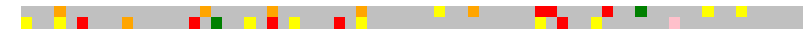

In [16]:
sim = TrafficSimulator_Two_Lanes(length=100, density=0.2, vMax=5, slowProb=0.5)
sim.initialize()
sim.update_velocities()
sim.step()
states = []
for _ in range(100):
#     sim.draw_all_lanes()
    sim.update_lanes()
    sim.update_velocities()
#     sim.draw_all_lanes()
    sim.step()
    states.append(sim.current_state[:, :70])

video_html = video_from_states(states, int)
HTML(video_html)